## The Taycan Turbo S: what Porsche doesn't want you to know! ##
### Or, what you can do with public vehicle data ###

![2020-porsche-taycan.jpg](img/2020-porsche-taycan.jpg)

First, a mantra: all models are wrong, some models are useful

In [1]:
using Unitful
using Interpolations
using DelimitedFiles
using Plots
using Polynomials
using DifferentialEquations

In [2]:
mass_veh = 2_358.7; #kg
A_frontal = 2.331866; #m^2
Cd = 0.25;
max_spd = 257.5; #kph
tire_r_front = 0.3595; #in m, 21" rims, 265/35 tires
tire_r_rear = 0.358; # in m, 21" rims, 305/30 tires
boost_time = 2.5; #s

In [3]:
#The stuff I had to guess
ϕ_p = 0.95;
slip_ratio = 1.15;
rr = 0.01;

In [4]:
#Physical constants
ρ=1.225; #kg/m^3
gn = ustrip(Unitful.gn);

In [5]:
# Calculated constants
f_traction_max = ϕ_p * mass_veh * gn;
traction_limit_tq= f_traction_max * ((tire_r_front+tire_r_rear)/2)
f_rr = rr*mass_veh*gn;

In [6]:
# Handy values to have around
spd_range = range(0,max_spd,length=1001);

![taycan_pt_tq.png](img/taycan_pt_tq.png)

We'll call the blue line `pt_max_tq` and load the [DataThief](https://datathief.org/) output into Julia

In [7]:
pt_max_tq = readdlm(
    "taycan_pt_tq.txt",
    ',',
    Float64,
    '\n',
    skipstart=1);

Similarly, we'll call the max torque for the rear axle in first gear `ra1_max_tq`. We'll also set the first speed point equal to zero since DataThief doesn't trace out.

In [8]:
ra1_max_tq = readdlm(
    "taycan_pt_tq_ra1.txt",
    ',',
    Float64,
    '\n',
    skipstart=1)
ra1_max_tq[1,1]=0.0;

And for second gear on the rear axle, we'll use `ra2_max_tq`. There's no shifting to zero like in first gear since the DataThief data doesn't fully reach the torque limited regime for the motor

In [9]:
ra2_max_tq = readdlm(
    "taycan_pt_tq_ra2.txt",
    ',',
    Float64,
    '\n',
    skipstart=1);

Finally, we'll call the front motor torque `fa_max_tq`

In [10]:
fa_max_tq = readdlm(
    "taycan_pt_tq_fa.txt",
    ',',
    Float64,
    '\n',
    skipstart=1);

Julia also provides some convenient interpolation functions, so we'll turn this data into something we can put into a simulation

In [11]:
max_tq_itp = LinearInterpolation(
    pt_max_tq[:,1], 
    pt_max_tq[:,2], 
    extrapolation_bc=Line()
);

ra1_max_itp = LinearInterpolation(
    ra1_max_tq[:,1],
    ra1_max_tq[:,2],
    extrapolation_bc = Line()
);

ra2_max_itp = LinearInterpolation(
    ra2_max_tq[:,1],
    ra2_max_tq[:,2],
    extrapolation_bc = Line()
);

fa_max_itp = LinearInterpolation(
    fa_max_tq[:,1],
    fa_max_tq[:,2],
    extrapolation_bc = Flat()
);

Interestingly, because the interpolations are functions, we can splice the two rear gears together pretty elegantly

In [12]:
ra_max_itp(spd) = max(ra1_max_itp(spd), ra2_max_itp(spd))

ra_max_itp (generic function with 1 method)

Porsche has also said that the can boost the rear motor to 610 Nm and 370 kW for 2.5 seconds, but again we can use the functional nature of the interpolation data to scale what Porsche has provided. It's not perfect, but it should be approximately correct. I've also previously estimated the gear ratio for first gear on the rear axle to be about 15.33

In [13]:
boosted_ra_max_itp(spd) = min(ra_max_itp(spd)*370/335, 610*15.33)

boosted_ra_max_itp (generic function with 1 method)

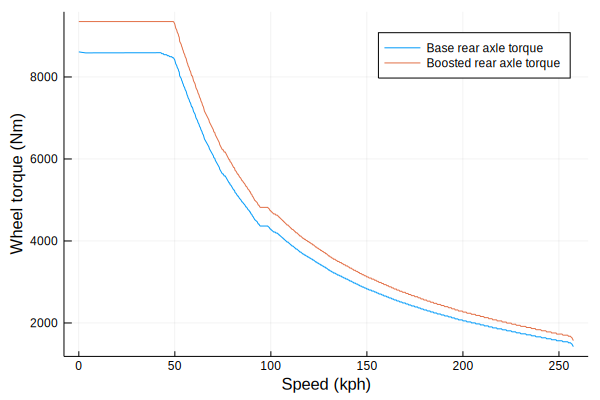

In [14]:
plot(
    spd_range,
    ra_max_itp.(spd_range),
    label = "Base rear axle torque",
    legend = :topright,
    xlabel = "Speed (kph)",
    ylabel = "Wheel torque (Nm)"
)
plot!(
    spd_range,
    boosted_ra_max_itp.(spd_range),
    label="Boosted rear axle torque"
)

Porsche has also said that the front motor can be boosted 440 Nm, but I believe the power is constant, so we need to do some more sophisticated extrapolation in order to estimate the higher torque performance. The `polyfit` below fits the power limited section of the motor performance and estimates the torque performance between the current max torque and the boosted value.  

In [15]:
pwr_idx = findfirst(x->x<3100, fa_max_tq[:,2]);
pwr_poly = polyfit(fa_max_tq[pwr_idx:end,1], fa_max_tq[pwr_idx:end,2],4);
boosted_fa_max_itp(spd) = min(440*8.05, pwr_poly(spd));

Let's do another plot comparison to make sure the resulting trends look correct.

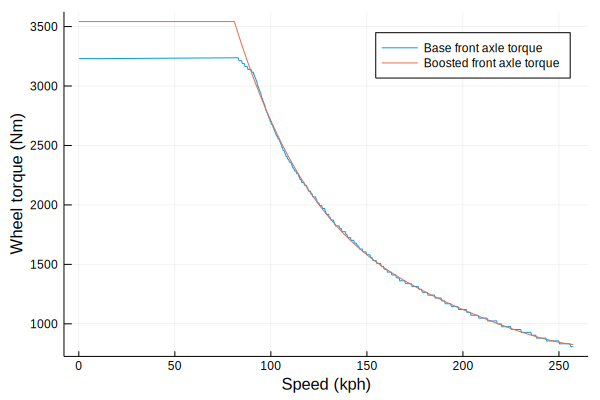

In [16]:
plot(
    spd_range,
    fa_max_itp.(spd_range),
    label = "Base front axle torque",
    legend = :topright,
    xlabel = "Speed (kph)",
    ylabel = "Wheel torque (Nm)"
)
plot!(
    spd_range,
    boosted_fa_max_itp.(spd_range),
    label="Boosted front axle torque"
)

We can define an equation for how much force the Turbo S can exert to accelerate itself. Ideally this would be a more generalized equation with values for the Turbo S passed, but that can be done later. 

In [17]:
F(v,t) = (
    min(
        if t < boost_time
            boosted_fa_max_itp(3.6*v*slip_ratio)/tire_r_front + boosted_ra_max_itp(3.6*v*slip_ratio)/tire_r_rear
        else
            max_tq_itp(3.6*v*slip_ratio)/((tire_r_front+tire_r_rear)/2)
        end,
        f_traction_max
    )
    - 0.5*Cd*ρ*A_frontal*v^2
    - f_rr
)

F (generic function with 1 method)

This translates into acceleration by dividing by the vehicle mass.

In [18]:
a(v,t) = F(v,t)/mass_veh

a (generic function with 1 method)

Using the `DifferentialEquations` package, we can easily define a simple differential equation that will model full throttle performance for the Turbo S. Simple is relative, but this will give us distance traveled, speed, and acceleration over time.

In [19]:
function perf_calc(du,u,p,t)
    du[1] = u[2]
    du[2] = u[3]
    u[3] = a(u[2],t)
end

perf_calc (generic function with 1 method)

We also want to set some initial conditions `u0` that just say we're starting at zero distance traveled, zero speed, and zero acceleration. Also, we want to run this "simulation" from zero to 30 seconds as most of what we're interested in can easily be done in that time.

In [20]:
u0 = [0.0, 0.0, 0.0];
tspan=(0.0,30.0);

Mercifully, the `DifferentialEquations` package allows us to set termination conditions for the simulation, so we can stop calculating when the vehicle hits 60 mph and see what the time is at that point.

In [21]:
condition(u,t,integrator) = u[2] - 26.8224; #60 mph in m/s
affect!(integrator) = terminate!(integrator);
cb = ContinuousCallback(condition,affect!);
zeroTo60_ode = ODEProblem(perf_calc, u0, tspan);
zeroTo60 = solve(zeroTo60_ode, callback=cb);
zeroTo60.t[end]

2.9162624121560072

In [22]:
zeroTo60.u[end][2]

26.822400000000002

So we can see that the final speed was reached pretty exactly, but the time is slightly longer than the Porsche quoted 2.6 seconds. So what's happening here? It's possible that my calculations are off, but it's also possible that Porsche is allowing for a 1 foot "rollout" in their measurements. Basically, 0-60 times are half physics and half manufacturer "discretion" in measurement.

However, we can see how long it takes the Turbo S to cover a foot from zero speed and subtract that off our previous answer.

In [23]:
condition(u,t,integrator) = u[1] - 0.3048; #1 ft in m
affect!(integrator) = terminate!(integrator);
cb = ContinuousCallback(condition, affect!);
rollout_ode = ODEProblem(perf_calc, u0, tspan);
rollout = solve(rollout_ode, callback=cb);
zeroTo60.t[end]-rollout.t[end]

2.659095605691652

This certainly seems close enough for a simple model using simple physics. What about the quarter mile? Porsche has said the Turbo S can do this in about 10.8 seconds.

In [24]:
condition(u,t,integrator) = u[1] - 402.336; #quarter mile in m
affect!(integrator) = terminate!(integrator);
cb = ContinuousCallback(condition, affect!);
quarter_mile_ode = ODEProblem(perf_calc, u0, tspan);
quarter_mile = solve(quarter_mile_ode, callback=cb);
quarter_mile.t[end]

10.788661474027707

Again, I'm calling this close enough. Granted, these numbers are also possible because I calibrated the tire `ϕ_p` parameter to match these results, so there is a risk of overfit here. But what about numbers Porsche hasn't released, like 0 to top speed?

In [25]:
condition(u,t,integrator) = u[2] - max_spd/3.6; #top speed in m/s
affect!(integrator) = terminate!(integrator);
cb = ContinuousCallback(condition, affect!);
top_speed_ode = ODEProblem(perf_calc, u0, tspan);
top_speed = solve(top_speed_ode, callback=cb);
top_speed.t[end]

16.991290338125506

Using highly scientific measurement from a [YouTube video of someone flooring a Turbo S](https://www.youtube.com/watch?v=SUeyRnqq49o), I'd estimate the real value for this is somewhere around 16.6 seconds. Again, not super accurate, but enough to give me confidence that I haven't just overfit the data, since this is less than 5% off. This is also within the realm of another calibratable parameter, which is the slip ratio, but I'll leave it at 15% for the time being.

But here's something I've been super curious about: did Porsche really need to give the Taycan a transmission on the rear axle? The plot below shows part of the reason I ask, keeping in mind that the upshift is somewhere between 75 and 100 kph.

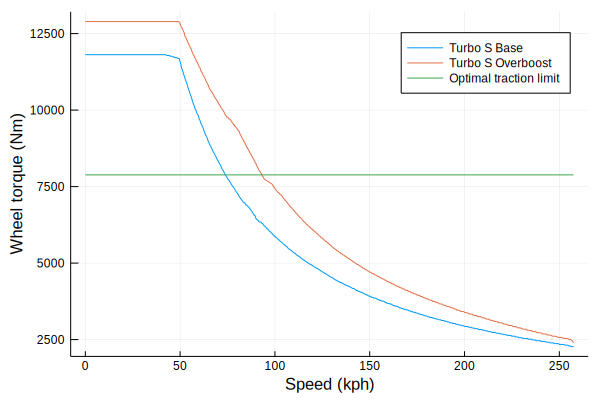

In [26]:
plot(
    spd_range, 
    max_tq_itp(spd_range),
    label="Turbo S Base",
    xlabel = "Speed (kph)",
    ylabel = "Wheel torque (Nm)",
    yaxis=[0 13000]
)
plot!(
    spd_range,
    boosted_fa_max_itp.(spd_range)+boosted_ra_max_itp.(spd_range),
    label = "Turbo S Overboost"
)
plot!(spd_range, traction_limit_tq*ones(size(spd_range)), label="Optimal traction limit")

We can see that below about 100 kph the limiting factor in delivering acceleration to the vehicle is the tires. In fact, it looks like the boosted performance of the Turbo S is in ridiculous excess of what can actually be used. Perhaps this is just for bragging rights; it is a Porsche after all. But we can model what the rear axle would look like with just the single gear, and calculate performance for that variant.

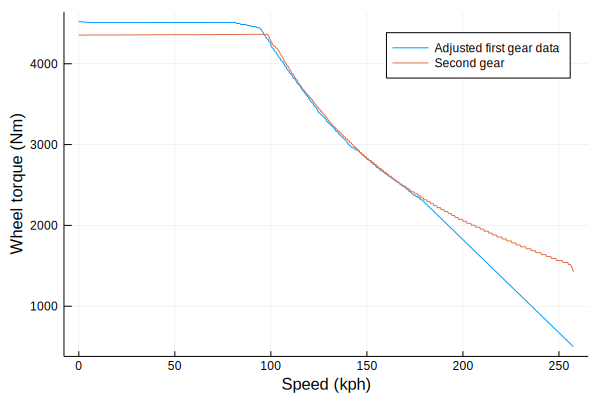

In [27]:
adj_factor = (8.05/15.33)

plot(
    spd_range, 
    ra1_max_itp(spd_range*adj_factor)*adj_factor,
    label = "Adjusted first gear data",
    xlabel = "Speed (kph)",
    ylabel = "Wheel torque (Nm)"
)
plot!(
    spd_range, 
    ra2_max_itp(spd_range),
    label="Second gear"
)

This data is quite messy, however, we can employ some of the tricks we used for the front motor here. We know what the max torque should be, and the second gear data shows the power limited performance pretty well. We can make another polynomial fit to the second gear data between about 105 and 250 kph, and min that with the max torque.

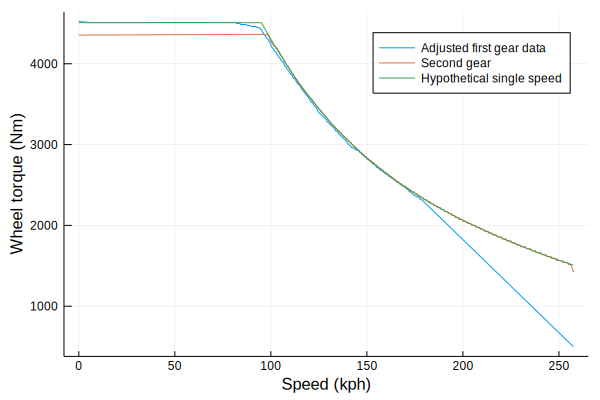

In [28]:
start_pwr_idx = findfirst(x->x>105, ra2_max_tq[:,1]);
end_pwr_idx = findfirst(x->x>250, ra2_max_tq[:,1]);
ss_pwr_poly = polyfit(
    ra2_max_tq[start_pwr_idx:end_pwr_idx,1], 
    ra2_max_tq[start_pwr_idx:end_pwr_idx,2],
    4);
single_speed_ra_max_itp(spd) = min(560*8.05, ss_pwr_poly(spd));
plot!(
    spd_range,
    single_speed_ra_max_itp.(spd_range),
    label = "Hypothetical single speed"
)

Now, we can simulate the performance for a single speed Turbo S, muhahahhahahaha!

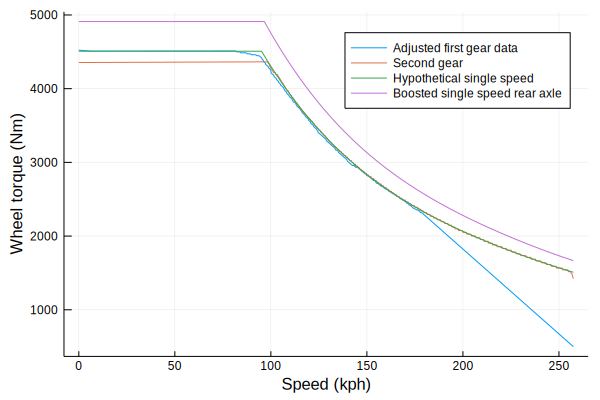

In [29]:
boosted_single_speed_ra_max_itp(spd) = min(single_speed_ra_max_itp(spd)*370/335, 610*8.05)
plot!(
    spd_range,
    boosted_single_speed_ra_max_itp.(spd_range),
    label="Boosted single speed rear axle"
)

In [30]:
F_single_speed(v,t) = (
    min(
        if t < boost_time
            boosted_fa_max_itp(3.6*v*slip_ratio)/tire_r_front + boosted_single_speed_ra_max_itp(3.6*v*slip_ratio)/tire_r_rear
        else
            max_tq_itp(3.6*v*slip_ratio)/((tire_r_front+tire_r_rear)/2)
        end,
        f_traction_max
    )
    - 0.5*Cd*ρ*A_frontal*v^2
    - f_rr
)

a_single_speed(v,t) = F_single_speed(v,t)/mass_veh

function single_speed_perf_calc(du,u,p,t)
    du[1] = u[2]
    du[2] = u[3]
    u[3] = a_single_speed(u[2],t)
end

nothing

In [31]:
condition(u,t,integrator) = u[2] - 26.8224; #60 mph in m/s
affect!(integrator) = terminate!(integrator);
cb = ContinuousCallback(condition,affect!);
ss_zeroTo60_ode = ODEProblem(single_speed_perf_calc, u0, tspan);
ss_zeroTo60 = solve(ss_zeroTo60_ode, callback=cb);
ss_zeroTo60.t[end]

2.9162624121560072

In [32]:
condition(u,t,integrator) = u[1] - 0.3048; #1 ft in m
affect!(integrator) = terminate!(integrator);
cb = ContinuousCallback(condition, affect!);
ss_rollout_ode = ODEProblem(single_speed_perf_calc, u0, tspan);
ss_rollout = solve(ss_rollout_ode, callback=cb);
ss_zeroTo60.t[end]-ss_rollout.t[end]

2.659095605691652

As a sanity check, let's look at that max torque plot again...

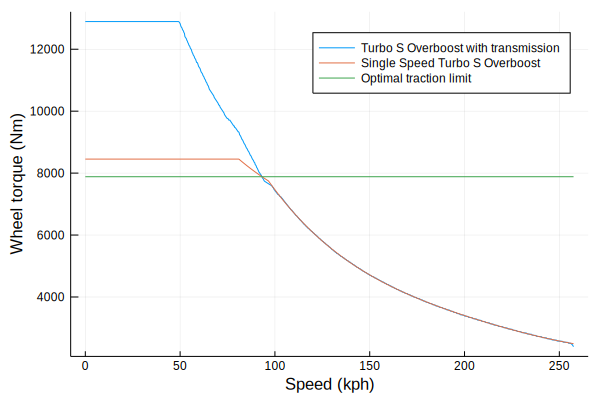

In [33]:
plot(
    spd_range, 
    boosted_fa_max_itp.(spd_range)+boosted_ra_max_itp.(spd_range),
    label="Turbo S Overboost with transmission",
    xlabel = "Speed (kph)",
    ylabel = "Wheel torque (Nm)",
    ylimit = [0 13000]
)
plot!(
    spd_range,
    boosted_fa_max_itp.(spd_range)+boosted_single_speed_ra_max_itp.(spd_range),
    label = "Single Speed Turbo S Overboost"
)
plot!(spd_range, traction_limit_tq*ones(size(spd_range)), label="Optimal traction limit")

So yes, the torque to the wheels is dramatically lowered, but it's still more than the tires can handle, so the performance is identical. It's possible this way of running the rear motor allows Porsche to have better sustained performance, as it may be more efficient at another operating point and therefore reject less heat. It may also be a matter of durability, weight transfer during acceleration, or a million of the messy concerns that pop up during actually building a vehicle. Still, the reason of "performance" for the selection of a transmission seems... suspect. Transmissions add considerably more complexity than a simple gearbox, so I'm sure Porsche has a good reason... right?